In [13]:
import pandas as pd
import numpy as np
import tqdm
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from sklearn.externals import joblib
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import warnings 

In [2]:
%matplotlib inline

data = pd.read_csv('da26521-0003.tsv', sep='\t', header=0)

def replace_missing(x):
    
    if len(str(x)) == 1 and x in [8, 5, 9]:
            return np.nan
        
    if len(str(x)) == 2 and x in [88, 95, 98, 99, 97]:
            return np.nan
        
    if len(str(x)) == 3 and x in [888, 995, 998, 999, 98.0]:
            return np.nan
        
    if len(str(x)) == 4 and x in [88.8, 99.5, 99.8, 8888, 9995, 9998, 9999]:
            return np.nan
        
    if len(str(x)) == 5 and x in [888.8, 999.5, 999.8, 88888, 99995, 99998, 99999]:
            return np.nan
        
    if len(str(x)) == 6 and x in [8888.8, 9999.5, 9999.8]:
            return np.nan    
    
    else:
        return x

data = data.applymap(lambda x: replace_missing(x)).copy()

def list_of_absent_data_columns(data, ratio=0.2):
    """returns list of columns whose missing values make up \
    more than a set ratio (default is half) of the data"""
    variables_list = list(data.columns)
    missing_list = []
    for variable in variables_list:
        missing_ratio = sum(data[variable].isna()) / len(data)
        if missing_ratio > ratio:
            missing_list.append(variable)
    return missing_list

absent_columns = list_of_absent_data_columns(data)

data.drop(columns=absent_columns, inplace=True)

def missing_vis(data):
    """Returns 4 graphics: bar chart, distributions, heatmap \
    (of correlation between nulls), and dendogram"""
    msno.bar(data);
    msno.matrix(data);
    msno.heatmap(data);
    msno.dendrogram(data);


data.shape

singular_variables = []
for col in data.columns:
#     print(col, len(set(prison_data[col])))
    if data[col].nunique() == 1:
        singular_variables.append(col)
print(singular_variables)


data.drop(columns = singular_variables, inplace=True)

data.columns

data.head()

data.shape

data = data.dropna()

data_clean = data[data['V55'] != 10].copy()

data_clean['outcome'] = data_clean['V55'].map(lambda x: 1 if x == 1 else 0)

data_clean['outcome'].value_counts()

data_clean.drop(columns='V55', inplace=True)

data_clean.drop(columns=['V96', 'V97', 'V98', 'V99'], inplace=True)

data_clean.columns

data_clean.shape

variable_names = {'V4': 'case_id',
                  'V8': 'birth_year',
                  'V9': 'sex',
                  'V10': 'race',
                  'V15': 'admission_year',
                  'V24': 'prior_jail_time',
                  'V25': 'prior_prison_time',
                  'V26': 'offense_1',
                  'V32': 'offense_longest_sentence',
                  'V33': 'length_longest_sentence',
                  'V34': 'total_max_sentence_length',
                  'V46': 'year_prison_release',
                  'V48': 'custody_agency_1',
                  'V51': 'release_type',
                  'V56': 'release_supervision_status',
                  'V57': 'age_admission',
                  'V58': 'age_prison_release',
                  'V59': 'age_parole_release',
                  'V62': 'time_served_current_admission',
                  'V67': 'time_served_parole',
                  'V70': 'total_max_sentence_indicator',
                  'V71': 'number_of_offenses_indicator',
                  'V94': 'state'}
variable_categories = {'key': ['case_id'],
                       'datetime': ['birth_year', 'admission_year', 'year_prison_release'],
                       'categorical': ['sex', 'race', 'offense_1', 'offense_longest_sentence', 'custody_agency_1',
                                       'release_type', 'release_supervision_status', 'number_of_offenses_indicator',
                                       'state'],
                       'numeric': ['prior_jail_time', 'prior_prison_time', 'age_admission', 'age_parole_release',
                                   'time_served_current_admission', 'time_served_parole'],
                       'mixed_numeric': ['length_longest_sentence', 'total_max_sentence_length',
                                         'total_max_sentence_indicator']}

descriptive_columns = list(variable_names.values())
descriptive_columns.append('outcome')
data_clean.columns = descriptive_columns
data_clean = pd.get_dummies(data_clean, columns=variable_categories['categorical'], 
                            drop_first=True)

data_clean.drop(columns=['race_2.0', 'race_3.0', 'race_4.0', 'race_6.0', 'sex_2.0'], inplace=True)

/home/peter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (95,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['V1', 'V2', 'V3', 'V5', 'V54', 'V95']


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.drop(columns=['outcome']), data_clean['outcome'])

# SVC Model

### Training

In [9]:
scaled_X_train = StandardScaler().fit_transform(X_train)

/home/peter/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/peter/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
test = LinearSVC(C=1, penalty="l1", dual=False, verbose=True, max_iter=10000).fit(scaled_X_train, y_train)

[LibLinear]

In [20]:
train_predict = test.predict(scaled_X_train)

In [21]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     59885
           1       0.94      0.77      0.85     60324

   micro avg       0.86      0.86      0.86    120209
   macro avg       0.87      0.86      0.86    120209
weighted avg       0.87      0.86      0.86    120209



### Test

In [22]:
scaled_X_test = StandardScaler().fit_transform(X_test)

/home/peter/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/peter/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [23]:
test_predict = test.predict(scaled_X_test)

In [24]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     19829
           1       0.94      0.77      0.85     20241

   micro avg       0.86      0.86      0.86     40070
   macro avg       0.87      0.86      0.86     40070
weighted avg       0.87      0.86      0.86     40070



In [27]:
confusion_matrix(y_test, test_predict)

array([[18861,   968],
       [ 4667, 15574]])

### Bias Analysis

#### Gender Bias

##### False Positives

Text(0.5, 1.0, 'False Positive')

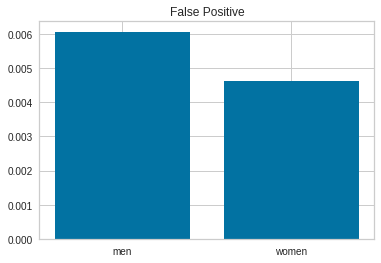

In [32]:
# Generate Dataframe with results and original dataset

preds = pd.concat([y_test, pd.Series(test_predict, name='pred', index=y_test.index), X_test], axis=1, ignore_index=False)

preds = pd.merge(preds, data[['V9', 'V10']], left_index=True, right_index=True)

# Calculate sex-based percentage of false positives

sex_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V9']

men_false_pos = sum(sex_false_pos == 1)/sum(data['V9'] == 1)

women_false_pos = sum(sex_false_pos == 2)/sum(data['V9'] == 2)

plt.bar(x=['men', 'women'], height=[men_false_pos, women_false_pos])
plt.title('False Positive')

##### False Negatives

Text(0.5, 1.0, 'False Negative')

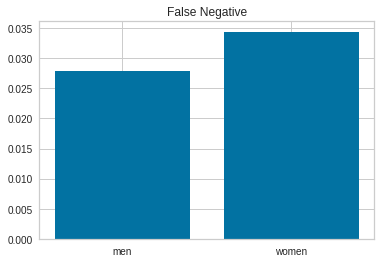

In [33]:
# Calculate sex-based percentage of false negatives

sex_false_neg = preds.loc[(preds['outcome'] == 1) & (preds['pred'] == 0)]['V9']

men_false_neg = sum(sex_false_neg == 1)/sum(data['V9'] == 1)

women_false_neg = sum(sex_false_neg == 2)/sum(data['V9'] == 2)

plt.bar(x=['men', 'women'], height=[men_false_neg, women_false_neg])
plt.title('False Negative')

#### Racial Bias

Text(0.5, 1.0, 'False Positive')

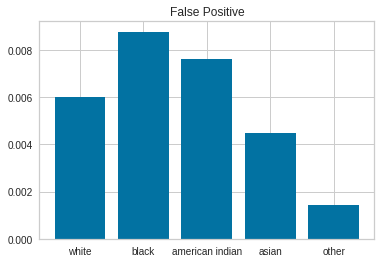

In [35]:
racial_false_pos = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_pos = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_pos = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_pos = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_pos = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_pos = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

plt.bar(x=['white', 'black', 'american indian', 'asian', 'other'], 
        height=[white_false_pos,
               black_false_pos,
               americanindian_false_pos,
               asian_false_pos,
               other_false_pos])
plt.title('False Positive')

<BarContainer object of 5 artists>

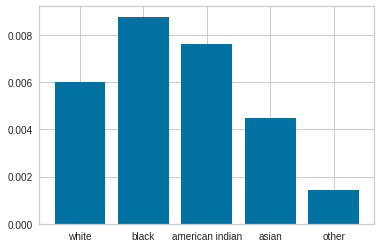

In [36]:
racial_false_neg = preds.loc[(preds['outcome'] == 0) & (preds['pred'] == 1)]['V10']

white_false_neg = sum(racial_false_pos == 1)/sum(data['V10'] == 1)

black_false_neg = sum(racial_false_pos == 2)/sum(data['V10'] == 2)

americanindian_false_neg = sum(racial_false_pos == 3)/sum(data['V10'] == 3)

asian_false_neg = sum(racial_false_pos == 4)/sum(data['V10'] == 4)

other_false_neg = sum(racial_false_pos == 6)/sum(data['V10'] == 6)

plt.bar(x=['white', 'black', 'american indian', 'asian', 'other'], 
        height=[white_false_neg,
               black_false_neg,
               americanindian_false_neg,
               asian_false_neg,
               other_false_neg])

### Model Viz

[LibLinear]

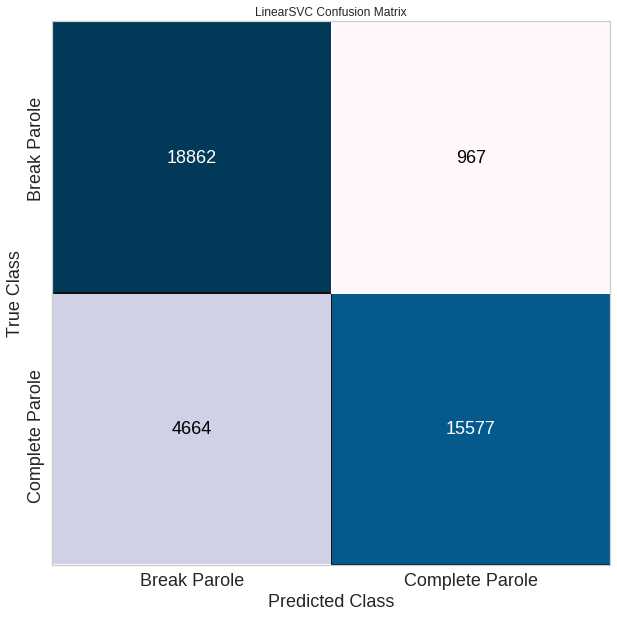

In [39]:
plt.figure(figsize=(10,10))
viz = ConfusionMatrix(LinearSVC(C=1, penalty="l1", dual=False, verbose=True, max_iter=10000).fit(scaled_X_train, y_train), cmap ='PuBu', fontsize=18)
viz.fit(scaled_X_test, y_train)
viz.score(scaled_X_test, y_test)
plt.xlabel('Predicted Class', fontsize=18)
plt.ylabel('Actual Class', fontsize=18)
plt.xticks(ticks = [0.5, 1.5], labels=['Break Parole', 'Complete Parole'], rotation=0)
plt.yticks(ticks = [0.7, 1.7], labels=['Complete Parole', 'Break Parole'], rotation=90)
viz.poof()